# Fitting a SDSS spectrum with Firefly

Here we fit a single SDSS spectrum using one setting within Firefly. With the script '../bin/SDSS/one_spectra.py' you can do a similar kind of run but looping over different convinations of stellar libraries and IMF to be output into a single file.

The first step to run Firefly is to set the enviromental variables so Python finds the code and the Stellar Population Models. 

Example for a .bashrc file:
```
$FF_DIR='[your path to Firefly]/firefly_code'
$PYTHONPATH=‘${FF_DIR}/python:$PYTHONPATH’
$STELLARPOPMODELS_DIR=‘[your path to Firefly]/stellar_population_models/'
```

Example for a .cshrc file:
```
setenv FF_DIR '[your path to Firefly]/firefly_code'
setenv PYTHONPATH ${PYTHONPATH}:${FF_DIR}/python
setenv STELLARPOPMODELS_DIR '[your path to Firefly]/stellar_population_models/'
```

Besides the standard useful Python packages, we need to downlad the specific Firefly packages. 

In [14]:
import sys, os.path
import numpy as np
import astropy.cosmology as co
import GalaxySpectrumFIREFLY as gs
import StellarPopulationModel as spm
from astropy.io import fits
from matplotlib import pyplot as plt
%matplotlib notebook

[GalaxySpectrumFIREFLY](http://www.mpe.mpg.de/~comparat/firefly_doc/GalaxySpectrumFIREFLY.html) Loads the environnement to transform observed spectra into the input for FIREFLY. The cosmology needs to be set:

In [15]:
cosmo=co.Planck13
print cosmo

FlatLambdaCDM(name="Planck13", H0=67.8 km / (Mpc s), Om0=0.307, Tcmb0=2.725 K, Neff=3.05, m_nu=[ 0.    0.    0.06] eV, Ob0=0.0483)


We have an example spectra from the SDSS, which name contain the Plate number and MJD and Fiber ids.

In [16]:
file_path = 'example_data/spectra/0266/spec-0266-51630-0623.fits'

# Check that the file actually exists
if (not os.path.isfile(file_path)):
    print 'Not found: ', file_path
    sys.exit()

base = os.path.basename(file_path).split('-')
plate = base[1] 
mjd   = base[2]
fiber, end = os.path.basename(base[3]).split('.')
print plate, mjd, fiber

0266 51630 0623


We pass the path to this file to [GalaxySpectrumFIREFLY](http://www.mpe.mpg.de/~comparat/firefly_doc/GalaxySpectrumFIREFLY.html) and we set this module to use the Milky Way reddening maps:

In [17]:
spec=gs.GalaxySpectrumFIREFLY(file_path, milky_way_reddening=True)
print type(spec)

<type 'instance'>


We set [GalaxySpectrumFIREFLY](http://www.mpe.mpg.de/~comparat/firefly_doc/GalaxySpectrumFIREFLY.html)  and 
 is set to read different formats of files with spectra: stacked for eBOSS, simulated for GAMA, etc. (see the documentation for more details.

In [18]:
spec.openObservedSDSSSpectrum(survey='sdssMain')
print spec.ra,spec.dec

145.89217 0.059412


At the moment Firefly has only spectral templates for galaxies and star clusters. Below we check if we actually have the spectra of an SDSS galaxy and if it's redshift is adecuatelly determined:

In [19]:
zz= spec.redshift ; print zz
if ((spec.hdulist[2].data['CLASS'][0]!="GALAXY")) or \
    (zz <=  spec.hdulist[2].data['Z_ERR'][0]) or \
    (spec.hdulist[2].data['Z_ERR'][0]<0) or \
    (spec.hdulist[2].data['ZWARNING'][0] !=0):
    print 'This is either not a galaxy or it has a poorly determined redshift.'
    sys.exit()

0.0633387


Firefly has spectra templates in a range of ages and metalliticities that depend on your choice of stellar libraries. The default age and metallicity ranges are set in **linear** units. If you want to restrict your minimisation further, make sure that you include these new limits also in **linear** units, as at the moment the code won't deal properly with logarithmic limits. Let's set the new age and metallicity limits for our run.

In [20]:
ageMin = 0.
ageMax = np.log10(cosmo.age(zz).value*1e9) #Gyr
ZMin = 0.001 #[Z/H]
ZMax = 4. 

The next step is to choose the stellar population model, stellar library and IMF. The directory 'stellar_population_model' containes all the provided options and further details are in [the documentation](http://www.mpe.mpg.de/~comparat/firefly_doc/StellarPopulationModel.html).

In [21]:
model = 'm11'      # Maraston & Stromback 2011
library = 'ELODIE' # Prugniel et al. 2007
imf = 'cha'        # Chabrier 2003

We set up now an output file. Note that the created directory 'output' is not tracked by git, so you won't see it in your directory, however it'll be created if you follow the commands presented here in your own script.

In [22]:
outputdir = '../output/'
if not os.path.exists(outputdir):
    os.makedirs(outputdir)

# Take part of the name of the input file for the output
outputfile = outputdir+'spFly-one-'+ os.path.basename(file_path)[5:-5]+'.fits'
print outputfile

../output/spFly-one-0266-51630-0623.fits


Let's populate the header of the output file with all the relevant information, making use of the [StellarPopulationModel](http://www.mpe.mpg.de/~comparat/firefly_doc/StellarPopulationModel.html):

In [23]:
prihdr = spm.pyfits.Header()
prihdr['FILE']          = os.path.basename(outputfile)
prihdr['PLATE']         = plate 
prihdr['MJD']           = mjd   
prihdr['FIBERID']       = fiber 
prihdr['MODELS']        = model
prihdr['FITTER']        = "FIREFLY"
prihdr['AGEMIN']        = str(ageMin)
prihdr['AGEMAX']        = str(ageMax)
prihdr['ZMIN']          = str(ZMin)
prihdr['ZMAX']          = str(ZMax)
prihdr['redshift']      = zz
prihdu = spm.pyfits.PrimaryHDU(header=prihdr)

We are going to run Firefly with the downgrade template libraries, 'use_downgraded_models = True'. You can downgrade the spectral templates to the resolution you need by setting 'downgrade_models = True', note that this is a long process.

In [24]:
tables = [prihdu]
try :
    bestfit = spm.StellarPopulationModel(spec, outputfile, cosmo, models = model, \
                                         model_libs = [library], imfs = [imf], \
                                         age_limits = [ageMin,ageMax], \
                                         downgrade_models = False, \
                                         data_wave_medium = 'vacuum', \
                                         Z_limits = [ZMin,ZMax], \
                                         use_downgraded_models = True, write_results = False)
    bestfit.fit_models_to_data()
    tables.append(bestfit.tbhdu )
    converged = True
except (ValueError):
    tables.append(bestfit.create_dummy_hdu())
    converged = False

The Firefly best fits will be stored as tables only if the fit converges.

In [25]:
if converged :
    complete_hdus = spm.pyfits.HDUList(tables)
    if os.path.isfile(outputfile):
        os.remove(outputfile)
    complete_hdus.writeto(outputfile)

Let's plot the best fit compared together with the original spectrum:

<IPython.core.display.Javascript object>


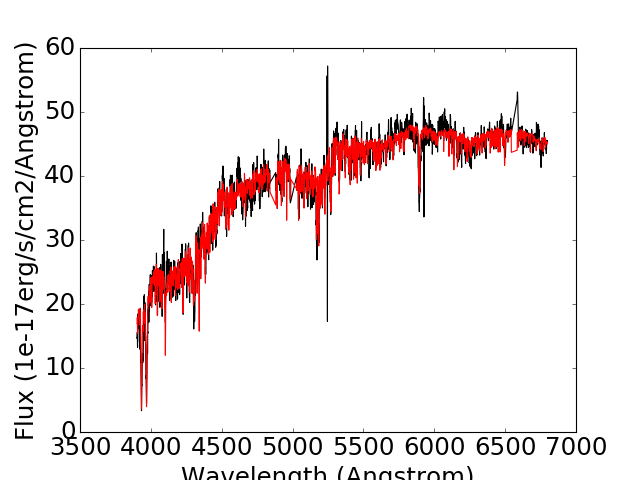

In [26]:
# Get the relevant data from the file
header =  fits.open(outputfile)  ; thefit = 1
wavelength = header[thefit].data['wavelength']
original_flux = header[thefit].data['original_data']
bestfit_model = header[thefit].data['firefly_model']

# Plot the spectra
plt.plot(wavelength, original_flux, 'k')
plt.plot(wavelength, bestfit_model, 'r')

# Add labels and tick marks
xtit = ('Wavelength (%s)' % header[thefit].header['TUNIT1'])
ytit = ('Flux (%s)' % header[thefit].header['TUNIT2'])
fn = 22 ; plt.xlabel(xtit, fontsize=fn) ; plt.ylabel(ytit, fontsize=fn)
plt.tick_params(axis='both', which='major', labelsize=fn)
plt.show()